In [2]:
import numpy as np
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from core.cluster_validation import morphotopes_to_etcs

In [3]:
regions_datadir = "/data/uscuni-ulce/"
linkage_dir = '/data/uscuni-ulce/processed_data/morphotope_linkage/'

model_params = '_75_0_None_None_False'

In [4]:
linkage_matrix = np.load(f'{linkage_dir}complete_euclidean_full.npy')
regional_clusters = pd.read_parquet(f'{linkage_dir}regional_clusters_2.5.pq').regional_cluster
regional_clusters_data = pd.read_parquet(f'{linkage_dir}regional_clusters_2.5_data.pq')
embedding = pd.read_parquet(f'{linkage_dir}regional_clusters_2.5_embedding.pq')
regional_ward_morphotopes_data = pd.read_parquet(f'{linkage_dir}regional_clusters_2.5_embedding_input.pq')

In [10]:
# lithuanian regions
region_ids = [139621, 139674, 139764, 140420, 141272, 141366, 142100, 143701, 145906,
       146285, 147112, 147634, 148018, 148085, 149997, 150044, 151676, 152081,
       152511]

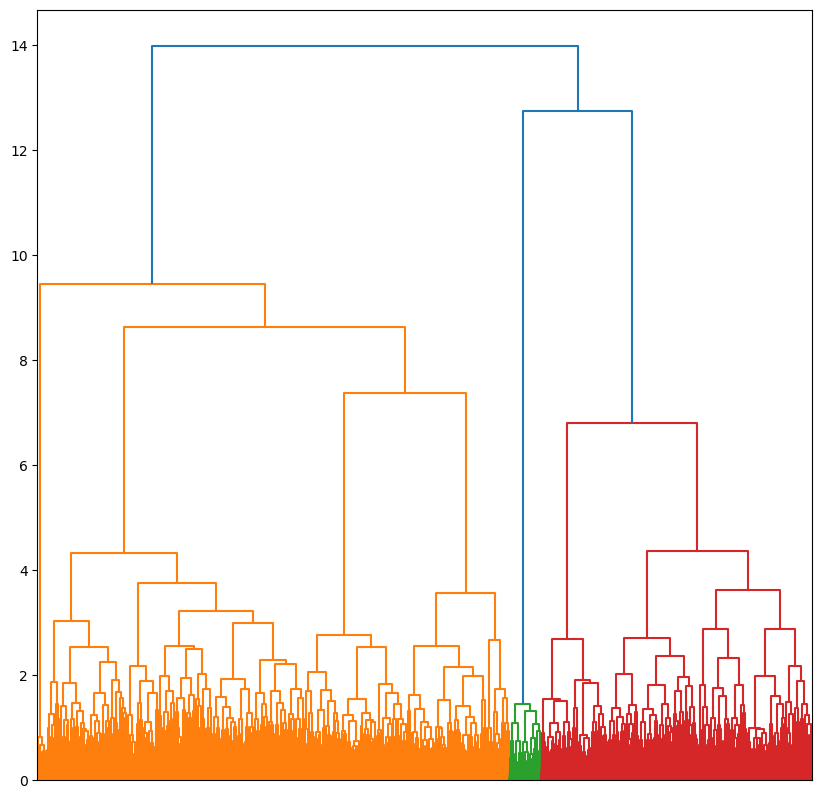

In [4]:
## final dendrogram
fig,ax = plt.subplots(figsize=(10,10))
_ = dendrogram(linkage_matrix,ax=ax, no_labels=True)

In [5]:
cluster_matrix = pd.DataFrame()

for cut in [10.0, 8.0, 6.0, 4.0, 2.5, 2.0, 1.5, 1.0, 0.5, 0.3]:
    clusters = fcluster(linkage_matrix, t=cut, criterion='distance')
    cluster_matrix[f'cut_at_level_{cut}'] = clusters

cluster_matrix.index = regional_ward_morphotopes_data.index

In [7]:
%%time

all_buildings = []

for region_id in region_ids:
    print(region_id)
    
    buildings = morphotopes_to_etcs(region_id, etcs=True, model_params=model_params)
    for cluster_column in cluster_matrix.columns:
        buildings[cluster_column] = buildings['morph'].map(lambda x: cluster_matrix[cluster_column].loc[regional_clusters.loc[x]] if x in regional_clusters else -1)
    
    buildings.index = str(region_id) + '_' + buildings.index.astype(str)
    buildings = buildings[['geometry', 'morph', 'cut_at_level_10.0',
       'cut_at_level_8.0', 'cut_at_level_6.0', 'cut_at_level_4.0',
       'cut_at_level_2.5', 'cut_at_level_2.0', 'cut_at_level_1.5',
       'cut_at_level_1.0', 'cut_at_level_0.5', 'cut_at_level_0.3']]
    all_buildings.append(buildings)

all_buildings = pd.concat(all_buildings)

139621
139674
139764
140420
141272
141366
142100
143701
145906
146285
147112
147634
148018
148085
149997
150044
151676
152081
152511
CPU times: user 1min 40s, sys: 2.66 s, total: 1min 43s
Wall time: 1min 43s


In [8]:
# map at the end for teh whole dataset
all_buildings['cut_at_level_0.0'] = all_buildings['morph'].map(lambda x: regional_clusters.loc[x] if x in regional_clusters else "-1").factorize()[0]
all_buildings['cut_at_level_morphotope'] = all_buildings['morph'].factorize()[0]

 #### Noise assignment

In [9]:
to_drop = [
        'stcSAl','stbOri','stcOri','stbCeA',
        'ldkAre', 'ldkPer', 'lskCCo', 'lskERI','lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe',
          'licBAD', 'misBAD',
    'ssbCCM','ssbCCD'    
]
chars_dir = '/data/uscuni-ulce/processed_data/chars/'
graph_dir = '/data/uscuni-ulce/processed_data/neigh_graphs/'

In [10]:
%%time

# read all characters for noise assignment
all_chars = []

for region_id in region_ids:
    chars = pd.read_parquet(f'{chars_dir}primary_chars_{region_id}.parquet')
    chars = chars.drop(columns=to_drop)
    chars.index = str(region_id) + '_' + chars.index.astype(str)
    all_chars.append(chars)
    
all_chars = pd.concat(all_chars)

CPU times: user 3.57 s, sys: 1.02 s, total: 4.58 s
Wall time: 985 ms


In [11]:
# make sure there are characters for all buildings
all_chars= all_chars.loc[all_buildings.index]
assert (all_chars.index == all_buildings.index).all()

In [12]:
%%time

# get morphotopes and noise groups values
is_noise = all_buildings.morph.str.split('_').str[-1] == '-1'

from libpysal.graph import read_parquet

all_noise_groups = []
bid_to_ngroup = []

for region_id in region_ids:
    print(region_id)
    tq1 = read_parquet(graph_dir + f"tessellation_graph_{region_id}.parquet")
    is_region_noise = is_noise & is_noise.index.str.startswith(str(region_id))
    noise_graph = tq1.subgraph(all_chars[is_region_noise].index.str.split('_').str[-1].astype(int))
    
    noise_groups = all_chars[is_region_noise].groupby(noise_graph.component_labels.values).median()
    noise_groups.index = str(region_id) + '_' + noise_groups.index.astype(str)
    
    region_bid_to_ngroup = str(region_id) + '_' + noise_graph.component_labels.astype(str)
    region_bid_to_ngroup.index = str(region_id) + '_' + region_bid_to_ngroup.index.astype(str)

    all_noise_groups.append(noise_groups)
    bid_to_ngroup.append(region_bid_to_ngroup)

all_noise_groups = pd.concat(all_noise_groups)
bid_to_ngroup = pd.concat(bid_to_ngroup)

139621
139674
139764
140420
141272
141366
142100
143701
145906
146285
147112
147634
148018
148085
149997
150044
151676
152081
152511
CPU times: user 16.9 s, sys: 388 ms, total: 17.3 s
Wall time: 17.1 s


In [13]:
all_buildings.columns


Index(['geometry', 'morph', 'cut_at_level_10.0', 'cut_at_level_8.0',
       'cut_at_level_6.0', 'cut_at_level_4.0', 'cut_at_level_2.5',
       'cut_at_level_2.0', 'cut_at_level_1.5', 'cut_at_level_1.0',
       'cut_at_level_0.5', 'cut_at_level_0.3', 'cut_at_level_0.0',
       'cut_at_level_morphotope'],
      dtype='object')

In [14]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.neighbors import KNeighborsClassifier

cluster_cols = ['cut_at_level_10.0', 'cut_at_level_8.0',
       'cut_at_level_6.0', 'cut_at_level_4.0', 'cut_at_level_2.5',
       'cut_at_level_2.0', 'cut_at_level_1.5', 'cut_at_level_1.0',
       'cut_at_level_0.5', 'cut_at_level_0.3']

In [15]:
%%time

for col in cluster_cols:

    ## the noise data stays the same for every clusters, but the actual tree data (clustered buildings) change at every cut
    clusters = all_buildings[[col, 'morph']]
    cluster_morph_medians = all_chars[~is_noise].groupby(clusters[~is_noise].morph.values).median()

    ## aggreate morphotope medians and noise in the same dataframe and normalise
    ## cannot use individual tess cells as takes too much time
    all_data = pd.concat((cluster_morph_medians, all_noise_groups))
    scalar = QuantileTransformer(subsample=None, output_distribution='uniform')
    vals = scalar.fit_transform(all_data)
    all_data = pd.DataFrame(vals, index=all_data.index, columns=all_data.columns).fillna(0)

    # morph -> final dictinary for final cluster assignment
    morph_to_final = pd.Series(clusters.loc[~is_noise, col].values,
                               clusters.loc[~is_noise, 'morph'].values)
    morph_to_final = morph_to_final[~morph_to_final.index.duplicated()]

    # setup the knn classifier tree and make predictions
    query_data = all_data.loc[all_noise_groups.index]
    tree_data = all_data.loc[cluster_morph_medians.index]
    tree = KNeighborsClassifier(n_neighbors=15, n_jobs=-1)
    tree = tree.fit(X=tree_data.values, y=morph_to_final.loc[tree_data.index].values)
    predictions = tree.predict(query_data.values)

    #map noise group clusters to building ids
    bid_to_prediction = bid_to_ngroup.map(pd.Series(predictions, query_data.index).to_dict())
    # assign new clusters, but make sure existing clusters are not changed
    new_clusters = all_buildings[col].copy()
    new_clusters.loc[bid_to_prediction.index.values] = bid_to_prediction.values.astype(int)
    pd.testing.assert_series_equal(all_buildings.loc[~is_noise, col], new_clusters[~is_noise])
    all_buildings[col] = new_clusters

CPU times: user 1min 10s, sys: 1.39 s, total: 1min 11s
Wall time: 35.7 s


In [21]:
# %%time
all_buildings.columns = ['geometry', 'morph', 'level_10.0', 'level_8.0', 'level_6.0', 'level_4.0',
       'level_2.5', 'level_2.0', 'level_1.5', 'level_1.0', 'level_0.5',
       'level_0.3', 'level_0.0', 'level_morph']

# Plotting

In [ ]:
# all_buildings = gpd.read_file('/data/uscuni-ulce/processed_data/outputs/lithuania/lithuania_tess').set_index('index')

In [23]:
etcs = all_buildings[all_buildings.index.str.startswith('151676')].copy()
etcs['geometry'] = etcs.simplify(1).to_crs(epsg=4326).make_valid()
etcs = etcs[etcs['geometry'].geom_type == 'Polygon']

In [28]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.PolygonLayer.from_geopandas(etcs, opacity=.07)

CPU times: user 945 ms, sys: 141 ms, total: 1.09 s
Wall time: 1.08 s


In [32]:
from sidecar import Sidecar
sc = Sidecar(title=f'Hierarchical Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)
    

In [30]:
from core.cluster_validation import get_color
col = 'level_1.0'
layer.get_fill_color = get_color(etcs[col])
np.unique(etcs[col].nunique())

array([65])

In [33]:
layer.get_line_color = [0, 0, 0]

In [34]:
%%time

all_buildings.to_file('/data/uscuni-ulce/processed_data/outputs/lithuania/lithuania_tess')

<timed eval>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


CPU times: user 16.3 s, sys: 2.33 s, total: 18.6 s
Wall time: 18.4 s


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'level_morph' to 'level_morp'
  ogr_write(


## Grid aggregation

In [44]:
# load data
all_buildings = gpd.read_file('/data/uscuni-ulce/processed_data/outputs/lithuania/lithuania_tess').set_index('index')
centroids = all_buildings.centroid
regions = gpd.read_parquet('/data/uscuni-ulce/regions/cadastre_regions_hull.parquet')
lithuania_bounds = regions.loc[region_ids].to_crs(epsg=4326).union_all().exterior

In [66]:
import h3
from shapely import Polygon
import shapely

def assign_hexagons(shape, centroids, h3_resolution = 9):
    '''Split `shape` intoh3 hexagons and assign all `centroids` to them.'''
    
    ## split region hull into hexagons
    bounds = shape
    poly = h3.geo_to_cells(bounds, res=h3_resolution)
    res = [shapely.geometry.shape(h3.cells_to_geo([p])) for p in poly]
    hexagons = gpd.GeoSeries(res, index=poly,name='geometry', crs='epsg:4326').to_crs(epsg=3035)

    # assign hexagons to tessellation cells
    inp, res = centroids.sindex.query(hexagons, predicate='intersects')
    # polygons should be assigned to only one h3 grid
    duplicated = pd.Series(res).duplicated()
    inp = inp[~duplicated]
    res = res[~duplicated]
    
    hex_assignments = pd.Series(hexagons.index[inp].values, centroids.index[res], name='hexagons').sort_index()
    return hexagons, hex_assignments

In [67]:
hexagons, hex_assignments = assign_hexagons(Polygon(lithuania_bounds.coords), centroids)

In [70]:
hexagons.shape, hex_assignments.index.shape, centroids.shape

((760770,), (2097059,), (2097323,))

In [153]:
grid_results = hexagons.to_frame()

In [154]:
positive = hex_assignments[~hex_assignments.index.str.split('_').str[-1].str.startswith('-')]

In [155]:
cluster_cols = ['level_10.0', 'level_8.0', 'level_6.0', 'level_4.0',
       'level_2.5', 'level_2.0', 'level_1.5', 'level_1.0', 'level_0.5',
       'level_0.3', 'level_0.0', 'level_morp']

In [156]:
%%time

for col in cluster_cols:
    
    # assign the most common building cluster within the hexagon, as the hexagons cluster
    res = all_buildings[col].groupby(positive).agg(lambda x: pd.Series.mode(x)[0])
    
    grid_results[col] = res

# drop all empty hexagons
to_plot = grid_results[~grid_results[cluster_cols].isna().all(axis=1)]

CPU times: user 1min 36s, sys: 277 ms, total: 1min 36s
Wall time: 1min 36s


##### Plot grid results

In [161]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.PolygonLayer.from_geopandas(to_plot, opacity=.05)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 801 ms, sys: 72.1 ms, total: 873 ms
Wall time: 871 ms


In [162]:
from sidecar import Sidecar
sc = Sidecar(title=f'Hierarchical Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)
    

In [168]:
from core.cluster_validation import get_color
col = 'level_2.5'
layer.get_fill_color = get_color(to_plot[col])
np.unique(to_plot[col].nunique())

array([21])

In [76]:
layer.get_line_color = [244,244,244]

In [167]:
all_buildings.to_file('/data/uscuni-ulce/processed_data/outputs/lithuania/lithuania_grid')